In [1]:
# Check GPU status
!nvidia-smi


Thu Sep  5 17:56:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (set

In [3]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
from sklearn.preprocessing import LabelEncoder


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns
from sklearn.manifold import TSNE


# torch geometrics
import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN
import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.transforms import RandomLinkSplit

from sklearn.metrics import roc_auc_score
# # Grape

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# # Grape
# from grape.datasets import get_all_available_graphs_dataframe
# from grape.datasets import get_dataset
from grape import Graph
from grape import GraphVisualizer

# # Ensmallen
# from grape.embedders import Node2VecCBOWEnsmallen, Node2VecGloVeEnsmallen, Node2VecSkipGramEnsmallen
# from grape.embedders import DeepWalkCBOWEnsmallen, DeepWalkGloVeEnsmallen, DeepWalkSkipGramEnsmallen
# from grape.embedders import WalkletsSkipGramEnsmallen, WalkletsCBOWEnsmallen, WalkletsGloVeEnsmallen
# from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
# #from grape.embedders import NetMFEnsmallen, GLEEEnsmallen, HOPEEnsmallen
from grape.embedders import TransEEnsmallen

# # TensorFlow
# from grape.embedders import SkipGramTensorFlow, CBOWTensorFlow
# from grape.embedders import FirstOrderLINETensorFlow, SecondOrderLINETensorFlow

# # KarateClub
# from grape.embedders import Role2VecKarateClub, GraRepKarateClub
# from grape.embedders import NMFADMMKarateClub, RandNEKarateClub


# # Edge prediction evaluation
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

# from grape.edge_prediction import KipfGCNEdgePrediction

# # Node Label prediction evaluation
# from grape.node_label_prediction import node_label_prediction_evaluation
# from grape.node_label_prediction import DecisionTreeNodeLabelPrediction, RandomForestNodeLabelPrediction, MLPNodeLabelPrediction, GradientBoostingNodeLabelPrediction#, PerceptronNodeLabelPrediction

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
# Load graph
view=1
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/content/drive/MyDrive/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [8]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [9]:
# IMPORT METHODS

# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [10]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [11]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

# train_data = Data(x=nodes_x,
#                   edge_index=edge_index, edge_type=edge_type,
#                   edge_label_index=edge_index,
#                   edge_label=torch.ones(edge_index.size(1))
#                     )

# train_data = train_data.to(device)

In [12]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

transform = RandomLinkSplit(is_undirected=False)

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
test_data = test_data.to(device)
val_data = val_data.to(device)

In [13]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 2365462  Test:675846  Validation: 337922


In [14]:
# Model

model = DistMult(
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=50, # The hidden embedding size.
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1000,
    shuffle=True,
)

optimizer =  optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

# ALTERNATIVE MODELS

# model_map = {
#     'transe': TransE,
#     'complex': ComplEx,
#     'distmult': DistMult,
#     'rotate': RotatE,
# }

# Proposed configurations
# optimizer_map = {
#     'transe': optim.Adam(model.parameters(), lr=0.01),
#     'complex': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
#     'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
#     'rotate': optim.Adam(model.parameters(), lr=1e-3),
# }

In [15]:
# Training definitions

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples


@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=20000,
        k=10,
    )

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

In [ ]:
# Training
n_epochs=26

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.9962
Epoch: 002, Loss: 0.8649
Epoch: 003, Loss: 0.5204
Epoch: 004, Loss: 0.3171
Epoch: 005, Loss: 0.2458
Epoch: 006, Loss: 0.2136
Epoch: 007, Loss: 0.1959
Epoch: 008, Loss: 0.1838
Epoch: 009, Loss: 0.1740
Epoch: 010, Loss: 0.1671
Epoch: 011, Loss: 0.1618
Epoch: 012, Loss: 0.1564
Epoch: 013, Loss: 0.1531
Epoch: 014, Loss: 0.1483
Epoch: 015, Loss: 0.1449
Epoch: 016, Loss: 0.1419
Epoch: 017, Loss: 0.1396
Epoch: 018, Loss: 0.1366
Epoch: 019, Loss: 0.1348
Epoch: 020, Loss: 0.1320
Epoch: 021, Loss: 0.1295
Epoch: 022, Loss: 0.1288
Epoch: 023, Loss: 0.1258
Epoch: 024, Loss: 0.1249
Epoch: 025, Loss: 0.1241


100%|██████████| 1182731/1182731 [27:17<00:00, 722.45it/s]


Epoch: 025, Val Mean Rank: 5060.84, Val MRR: 0.0116, Val Hits@10: 0.0221


In [ ]:
# Training
n_epochs=26

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.1221
Epoch: 002, Loss: 0.1213
Epoch: 003, Loss: 0.1200
Epoch: 004, Loss: 0.1188
Epoch: 005, Loss: 0.1183
Epoch: 006, Loss: 0.1182
Epoch: 007, Loss: 0.1170
Epoch: 008, Loss: 0.1156
Epoch: 009, Loss: 0.1155
Epoch: 010, Loss: 0.1146
Epoch: 011, Loss: 0.1141
Epoch: 012, Loss: 0.1130
Epoch: 013, Loss: 0.1126
Epoch: 014, Loss: 0.1114
Epoch: 015, Loss: 0.1113
Epoch: 016, Loss: 0.1114
Epoch: 017, Loss: 0.1106
Epoch: 018, Loss: 0.1102
Epoch: 019, Loss: 0.1094
Epoch: 020, Loss: 0.1091
Epoch: 021, Loss: 0.1085
Epoch: 022, Loss: 0.1083
Epoch: 023, Loss: 0.1073
Epoch: 024, Loss: 0.1072
Epoch: 025, Loss: 0.1072


100%|██████████| 1182731/1182731 [27:16<00:00, 722.85it/s]


Epoch: 025, Val Mean Rank: 4743.84, Val MRR: 0.0132, Val Hits@10: 0.0241


In [ ]:
# Testing
rank, mrr, hits_at_10 = test(test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 1351692/1351692 [31:12<00:00, 722.03it/s]


Test Mean Rank: 4921.63, Test MRR: 0.0130, Test Hits@10: 0.0238


In [ ]:
## EXTERNAL TEST SETS

## VIEW 0-2
test_sets = ['miRNA-disease2bepred']
test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
#test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
#test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.txt", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test-.txt",names=["subject","predicate","object"], sep='\t')

In [ ]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 12], [True, 16900]]


In [ ]:
rank, mrr, hits_at_10 = test(external_test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 16900/16900 [00:24<00:00, 695.82it/s]

Test Mean Rank: 14532.97, Test MRR: 0.0237, Test Hits@10: 0.0543


In [ ]:
node_embedding = pd.DataFrame(model.node_emb.weight.cpu().detach().numpy())

label_encoder = LabelEncoder()
node_types = label_encoder.fit_transform(list(nodes_df.type))
node_embedding.index = nodes_df
len(node_embedding)

85064

In [ ]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
"(<http://purl.obolibrary.org/obo/MONDO_0007247>, Disease)",-0.016666,0.074703,4.907619e-39,-0.018454,0.073584,0.018870,-0.072033,0.015444,0.016506,0.074672,...,-0.009475,-4.904683e-39,-0.072779,-0.074589,-0.075350,-0.015846,-0.073678,-0.075239,0.020576,-0.018881
"(<https://www.mirbase.org/mature/MIMAT0015042>, miRNA)",-0.224474,-0.177604,-4.910701e-39,-0.221514,-0.176680,0.223534,0.171684,0.226191,0.229471,-0.177892,...,-0.228161,4.908042e-39,0.179080,0.176085,0.174156,-0.217468,0.170767,0.172484,0.226914,-0.220907
"(<http://purl.obolibrary.org/obo/UBERON_0002195>, Anatomy)",0.032339,0.018368,4.912923e-39,0.030425,0.015761,-0.031914,-0.013184,-0.028955,-0.033350,0.019274,...,0.038326,-4.909620e-39,-0.013808,-0.016049,-0.014920,0.037158,-0.017778,-0.017193,-0.029119,0.032414
"(<http://purl.obolibrary.org/obo/MONDO_0004583>, Disease)",-0.034127,0.078363,4.914239e-39,-0.031420,0.076875,0.031143,-0.076925,0.031198,0.032771,0.078259,...,-0.038161,-4.911285e-39,-0.077016,-0.076375,-0.077645,-0.039025,-0.077188,-0.076514,0.029426,-0.035207
"(<http://purl.obolibrary.org/obo/GO_0060761>, GO)",-0.019613,0.094472,4.904725e-39,-0.012273,0.092726,0.016929,-0.092653,0.016332,0.024548,0.094269,...,-0.021435,4.916400e-39,-0.091858,-0.092735,-0.093055,-0.022697,-0.092826,-0.095622,0.014766,-0.016632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(<http://purl.obolibrary.org/obo/MONDO_0010781>, Disease)",-0.085564,0.013814,4.917308e-39,-0.084308,0.013906,0.083875,-0.010262,0.081621,0.091566,0.014423,...,-0.089143,4.906806e-39,-0.013478,-0.014655,-0.014620,-0.087436,-0.014295,-0.013417,0.084639,-0.084671
"(<http://purl.obolibrary.org/obo/HP_0100454>, Phenotype)",-0.003521,-0.016101,-4.915217e-39,-0.002967,-0.015555,0.002752,0.016235,0.003648,0.002906,-0.015356,...,0.001529,-4.910055e-39,0.016092,0.014906,0.016405,-0.001913,0.015200,0.015735,0.003606,-0.004695
"(<http://www.ncbi.nlm.nih.gov/gene/57101>, Gene)",0.092226,-0.074107,-4.907400e-39,0.093319,-0.069150,-0.091714,0.072948,-0.090777,-0.091848,-0.071344,...,0.097701,4.916468e-39,0.080790,0.076758,0.075388,0.092650,0.075290,0.076332,-0.087944,0.086763
"(<http://www.ncbi.nlm.nih.gov/gene/51316>, Gene)",0.116423,-0.108937,-4.904945e-39,0.113027,-0.104269,-0.117980,0.107254,-0.113685,-0.118893,-0.103822,...,0.118855,-4.909289e-39,0.109254,0.109475,0.107275,0.111082,0.101587,0.102362,-0.120233,0.113880


In [ ]:
!ls -lh


total 8.0K
drwx------ 5 root root 4.0K Jul 28 09:16 drive
drwxr-xr-x 1 root root 4.0K Jul 25 13:21 sample_data


In [ ]:
node_embedding.to_csv('node_embeddings.csv', header=False, index=True, sep=',')

In [ ]:
%matplotlib inline

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

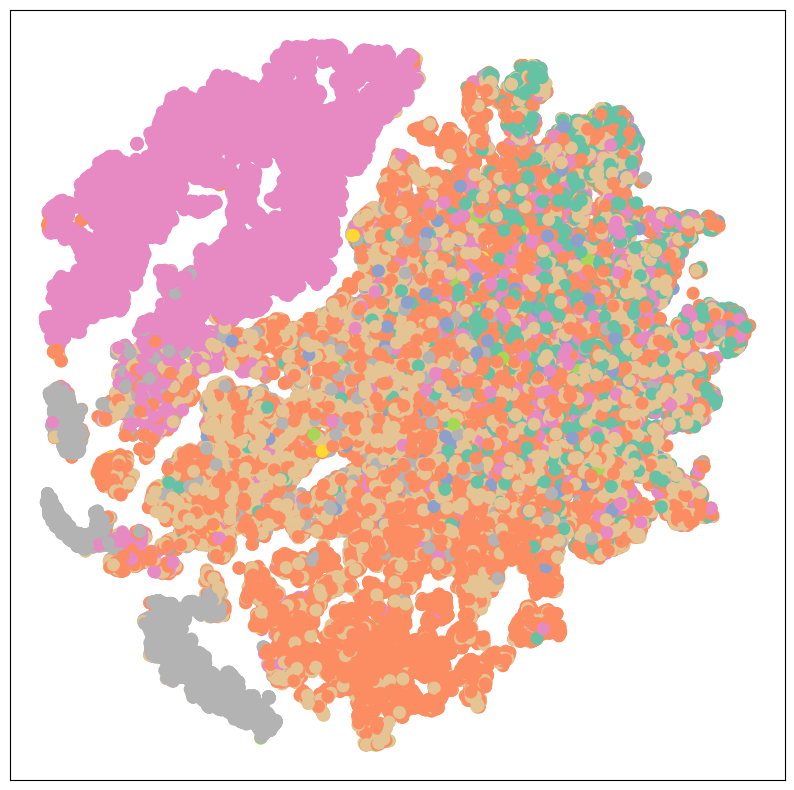

In [ ]:
visualize(node_embedding,node_types)

In [16]:
node_embeddings = pd.read_csv('/content/drive/MyDrive/models_thesis/mayank/view1_dismult_node_embeddings.csv', header= None)

In [17]:
node_embeddings

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,('<http://purl.obolibrary.org/obo/MONDO_000724...,-0.016666,0.074703,4.907619e-39,-0.018454,0.073584,0.018870,-0.072033,0.015444,0.016506,...,-0.009475,-4.904683e-39,-0.072779,-0.074589,-0.075350,-0.015846,-0.073678,-0.075239,0.020576,-0.018881
1,('<https://www.mirbase.org/mature/MIMAT0015042...,-0.224474,-0.177604,-4.910700e-39,-0.221514,-0.176680,0.223534,0.171684,0.226191,0.229471,...,-0.228161,4.908042e-39,0.179080,0.176085,0.174156,-0.217468,0.170767,0.172484,0.226914,-0.220907
2,('<http://purl.obolibrary.org/obo/UBERON_00021...,0.032339,0.018368,4.912923e-39,0.030425,0.015761,-0.031914,-0.013184,-0.028955,-0.033350,...,0.038326,-4.909620e-39,-0.013808,-0.016049,-0.014920,0.037158,-0.017778,-0.017193,-0.029119,0.032414
3,('<http://purl.obolibrary.org/obo/MONDO_000458...,-0.034127,0.078363,4.914239e-39,-0.031420,0.076875,0.031143,-0.076925,0.031198,0.032771,...,-0.038161,-4.911285e-39,-0.077016,-0.076375,-0.077645,-0.039025,-0.077188,-0.076514,0.029426,-0.035207
4,('<http://purl.obolibrary.org/obo/GO_0060761>'...,-0.019613,0.094472,4.904725e-39,-0.012273,0.092726,0.016929,-0.092653,0.016332,0.024548,...,-0.021435,4.916400e-39,-0.091858,-0.092735,-0.093055,-0.022697,-0.092826,-0.095622,0.014766,-0.016632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85059,('<http://purl.obolibrary.org/obo/MONDO_001078...,-0.085564,0.013814,4.917308e-39,-0.084308,0.013906,0.083875,-0.010262,0.081621,0.091566,...,-0.089143,4.906806e-39,-0.013478,-0.014655,-0.014620,-0.087436,-0.014295,-0.013417,0.084639,-0.084671
85060,('<http://purl.obolibrary.org/obo/HP_0100454>'...,-0.003521,-0.016101,-4.915217e-39,-0.002967,-0.015555,0.002752,0.016235,0.003648,0.002906,...,0.001529,-4.910055e-39,0.016092,0.014906,0.016405,-0.001913,0.015200,0.015735,0.003606,-0.004695
85061,"('<http://www.ncbi.nlm.nih.gov/gene/57101>', '...",0.092226,-0.074107,-4.907400e-39,0.093319,-0.069150,-0.091714,0.072948,-0.090777,-0.091848,...,0.097701,4.916468e-39,0.080790,0.076758,0.075388,0.092650,0.075290,0.076332,-0.087944,0.086763
85062,"('<http://www.ncbi.nlm.nih.gov/gene/51316>', '...",0.116423,-0.108937,-4.904945e-39,0.113027,-0.104269,-0.117980,0.107254,-0.113685,-0.118893,...,0.118855,-4.909290e-39,0.109254,0.109475,0.107275,0.111082,0.101587,0.102362,-0.120233,0.113880


In [21]:
node_embeddings.set_index(node_embeddings.columns[0], inplace=True)

In [22]:
node_embeddings.values

array([[-1.66663210e-02,  7.47026100e-02,  4.90761900e-39, ...,
        -7.52385260e-02,  2.05763450e-02, -1.88813300e-02],
       [-2.24474270e-01, -1.77604050e-01, -4.91070000e-39, ...,
         1.72484070e-01,  2.26914150e-01, -2.20906720e-01],
       [ 3.23390960e-02,  1.83677820e-02,  4.91292300e-39, ...,
        -1.71932760e-02, -2.91189890e-02,  3.24143170e-02],
       ...,
       [ 9.22263860e-02, -7.41073200e-02, -4.90740000e-39, ...,
         7.63319700e-02, -8.79436660e-02,  8.67631960e-02],
       [ 1.16422996e-01, -1.08937010e-01, -4.90494500e-39, ...,
         1.02361890e-01, -1.20232540e-01,  1.13880046e-01],
       [ 7.61789800e-02, -6.51864900e-02, -4.91560600e-39, ...,
         6.60838700e-02, -7.49391500e-02,  7.63836500e-02]])

In [18]:
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [19]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [23]:
# Assuming node_embedding index is a tuple of (URI, type)
node_embeddings.index = [name[0] for name in node_embeddings.index]

In [24]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=node_embeddings.values,  # Use simplified embedding features
    smoke_test=True,
    enable_cache=False
)

Evaluating on VIEW1_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

In [25]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINE.csv"
results.to_csv(filename)

In [26]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,accuracy,miss_rate,negative_predictive_value,false_discovery_rate,prevalence,false_omission_rate,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.498084,0.043843,0.477154,0.501000,0.5,0.522846,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.501716,0.036840,0.522258,0.499107,0.5,0.477742,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.498081,0.043647,0.477005,0.501001,0.5,0.522995,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.501290,0.036574,0.517038,0.499329,0.5,0.482962,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.498047,0.042059,0.475656,0.501017,0.5,0.524344,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.501154,0.035813,0.515610,0.499401,0.5,0.484390,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.498013,0.043476,0.476057,0.501036,0.5,0.523943,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.501330,0.036869,0.517411,0.499308,0.5,0.482589,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.498205,0.043329,0.478389,0.500936,0.5,0.521611,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.501358,0.037275,0.517579,0.499294,0.5,0.482421,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


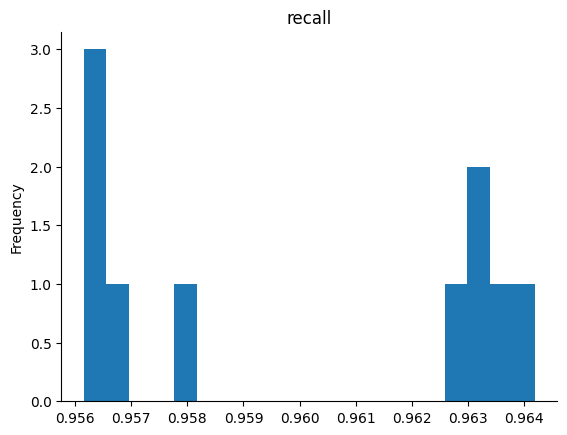

In [27]:
from matplotlib import pyplot as plt
results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = node_embeddings.values
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.6332
Precision: 0.6017
Recall: 0.6332


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
